<a href="https://colab.research.google.com/github/jdcarrascali/Matematicas-del-aprendizaje-de-maquinas/blob/main/Bank_note_authentication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
#Librerias utilizadas
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
import numpy as np
import scipy
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import weibull_min
from scipy.optimize import minimize
style.use('ggplot') 

#Librerías sklearn

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

#Librerías usadas para redes neuronales



import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l2, l1
from keras.metrics import BinaryAccuracy


drive.mount('/content/drive')
#Montaje de la carpeta de trabajo
os.chdir('/content/drive/MyDrive/svm')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Descripción del data set bank note**



Estos datos fueron extraídos de imágenes de billetes tanto falsificados como genuinos. Para su digitalización, fue usada una cámara industrial. Las imágenes obtenidas tienen una resolución de 400x400 píxeles. Se hace uso de la transformada wavelet para extraer características relevantes de las imágenes.   

1. Varianza de la transformada Wavelet de la imagen 
2. Simetría de la transformada Wavelet de la imagen
3. Curtosis de la transformada Wavelet de la imagen
4. Entropía de la imagen 
5. Clase: Falso -1, verdadero 1.

In [90]:
data_bank=pd.read_csv('data_banknote_authentication.txt',sep=',',names=["variance","skewness","curtosis","entropy","class"],
                      dtype={"variance":np.float64,"skewness":np.float64,"curtosis":np.float64,
                              "entropy":np.float64,"class":int})
data_bank["class"]=data_bank[['class']].replace(0,-1)

data_bank.describe()

#Separación del conjunto de datos en entrenamiento, validación y testeo.

train, validation, test = np.split(data_bank.sample(frac=1), [int(.6*len(data_bank)),
int(.8*len(data_bank))])

In [91]:
#Búsqueda de valores NA's
def missings(x):
            a = sum(x.isna())
            b = 100*np.mean(x.isna())
            c = pd.Series({"Missings": a,"%Missings": b})
            return(c)
data_bank.apply(missings,axis=0)

,variance,skewness,curtosis,entropy,class
Missings,0.0,0.0,0.0,0.0,0.0
%Missings,0.0,0.0,0.0,0.0,0.0


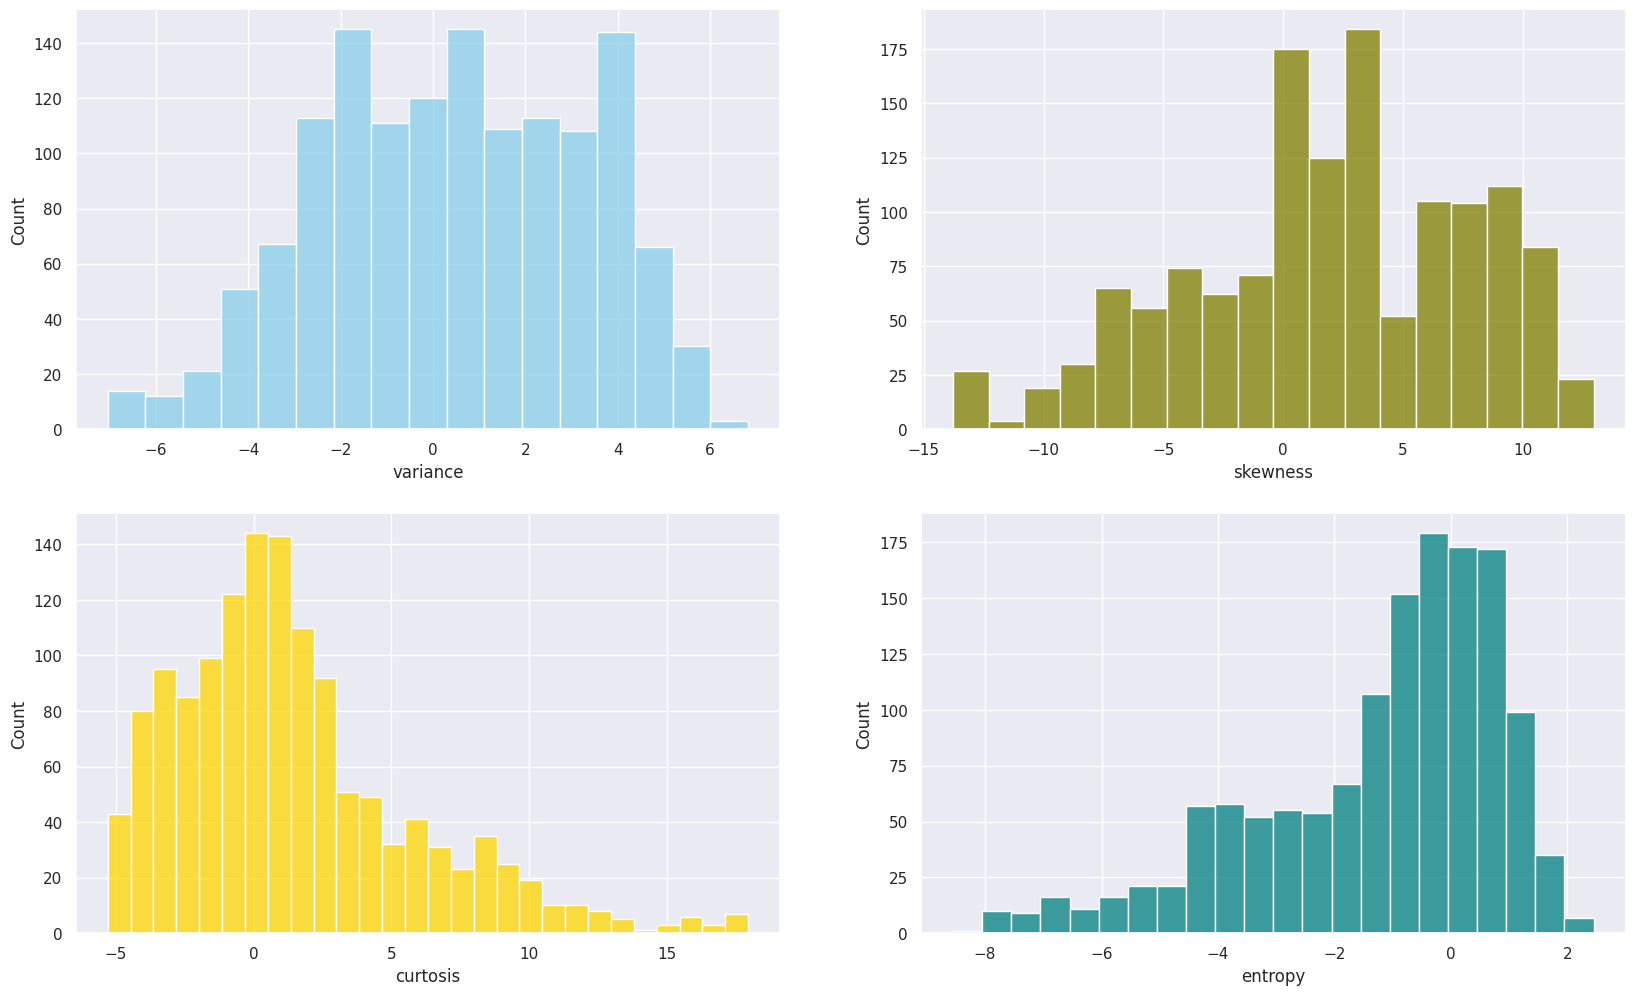

In [92]:
#Frecuencias
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

sns.histplot(data=data_bank["variance"], color="skyblue", ax=axs[0, 0])
sns.histplot(data=data_bank["skewness"], color="olive", ax=axs[0, 1])
sns.histplot(data=data_bank["curtosis"], color="gold", ax=axs[1, 0])
sns.histplot(data=data_bank["entropy"], color="teal", ax=axs[1, 1])
plt.show()

<Axes: xlabel='class', ylabel='Count'>

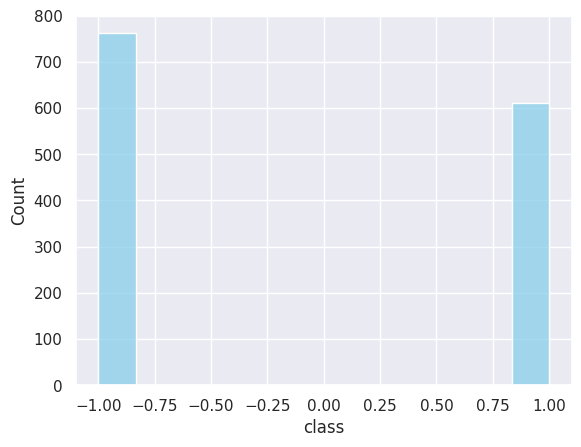

In [93]:
sns.histplot(data=data_bank["class"], color="skyblue")

No observamos un alto desbalance de clases en la clasificación.

#Elección métrica de desempeño

Obtamos por elegir "precision", esto es, es el número de elementos identificados correctamente como positivos de un total de elementos identificados como positivos.:
\begin{equation*}
Precision=\frac{TP}{TP+FP}
\end{equation*}
La elección de esta métrica se debe a que consideramos más grave que el sistema decida que un billete es autentico siendo que en realidad este es falsificado. 

Una descripción teorica de los algoritmos utilizados puede encontrarse en el notebook "Occupancy detection" de este mismo repositorio

Dado que consideramos que la muestra parece estar balanceada haremos la partición de la siguiente forma:

In [94]:
#Separación del conjunto de datos en entrenamiento, validación y testeo.
#Partición 80,10,10

train, validation, test = np.split(data_bank.sample(frac=1, random_state=1), [int(.7*len(data_bank)),
int(.85*len(data_bank))])

In [95]:
train.shape

(960, 5)

In [96]:
test.shape

(206, 5)

In [97]:
validation.shape

(206, 5)

In [98]:
#Preparación datos de entrenamiento,validación y testeo
#Como no hay alta dispersión de los datos, no normalizamos
#Ya viene hecha la partición

X_train = train.drop(columns=['class'], axis=1)
y_train = train['class']
X_validation = validation.drop(columns=['class'], axis=1)
y_validation = validation['class']
X_test = test.drop(columns=['class'], axis=1)
y_test = test['class']

#Implementación support vector machines


In [99]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [104]:
y_pred = svm_model.predict(X_validation)
print("Precision score en el conjunto de validación para una SVM : {}%".format(round((precision_score(y_validation, y_pred, average='macro')*100),2)))

Precision score en el conjunto de validación para una SVM : 99.49%


In [105]:
y_pred = svm_model.predict(X_test)
print("Precision score en el conjunto de test para una SVM : {}%".format(round((precision_score(y_test, y_pred, average='macro')*100),2)))
#Buen desempeño en validación y test

Precision score en el conjunto de test para una SVM : 99.47%


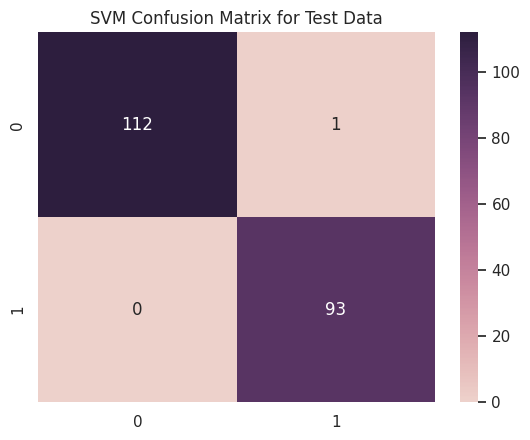

In [106]:
#Matriz de confusión para el desempeño en el conjunto de test
y_pred = svm_model.predict(X_test)
plt.title("SVM Confusion Matrix for Test Data", fontdict={'fontsize':12})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=sns.cubehelix_palette(as_cmap=True), annot=True, fmt="d")

#Implementación Logistic regression

In [112]:
#Entrenamiento del modelo
log_reg=LogisticRegression(random_state=0).fit(X_train, y_train)

In [113]:
#Desempeño en el conjunto de entrenamiento
y_pred=log_reg.predict(X_train)
print("Precision score en el conjunto de entrenamiento para una regresión logística : {}%".format(round((precision_score(y_train, y_pred, average='macro')*100),2)))

Precision score en el conjunto de entrenamiento para una regresión logística : 98.89%


In [120]:
#Desempeño en el conjunto de validación
y_pred=log_reg.predict(X_validation)
print("Precision score en el conjunto de validación para una regresión logística : {}%".format(round((precision_score(y_validation, y_pred, average='macro')*100),2)))

Precision score en el conjunto de validación para una regresión logística : 99.0%


In [122]:
#Desempeño en el conjunto de test
#Mismo desempeño en test que SVM
y_pred=log_reg.predict(X_test)
print("Precision score en el conjunto de validación para una regresión logística : {}%".format(round((precision_score(y_test, y_pred, average='macro')*100),2)))

Precision score en el conjunto de validación para una regresión logística : 99.47%


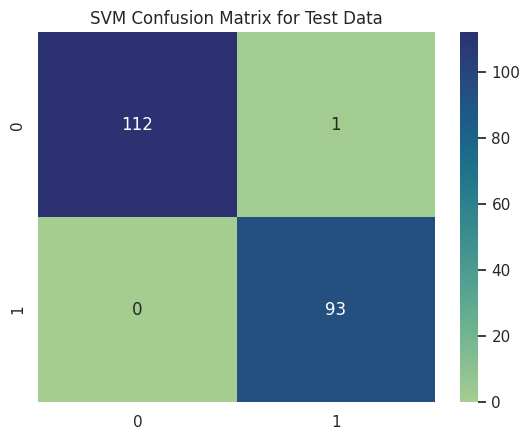

In [123]:
plt.title("SVM Confusion Matrix for Test Data", fontdict={'fontsize':12})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), cmap="crest", annot=True, fmt="d")

#Implementación KNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier
# Optimización de parametros para knn
n_neighbors_list = [7,15,45,135] #Posibles parametros para k
weights_list = ['uniform', 'distance']
metric_list = ['euclidean', 'manhattan']
accuracies = {}
for n in n_neighbors_list:
    for weight in weights_list:
        for metric in metric_list:
            knn_model = KNeighborsClassifier(n_neighbors=n, weights=weight, metric=metric)
            knn_model.fit(X_train, y_train)
            y_pred=knn_model.predict(X_validation)
            accuracy =precision_score(y_validation, y_pred, average='macro')
            accuracies[str(n)+"/"+weight+"/"+metric] = accuracy

In [130]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot
plotdata = pd.DataFrame()
plotdata['Parameters'] = accuracies.keys()
plotdata['Precision score'] = accuracies.values()
fig = px.line(plotdata, x="Parameters", y="Precision score")
fig.update_layout(title={'text': "Precision score for Different Hyper-Parameters",
                                                'x':0.5,
                                                'xanchor': 'center',
                                                'yanchor': 'top'})
iplot(fig)

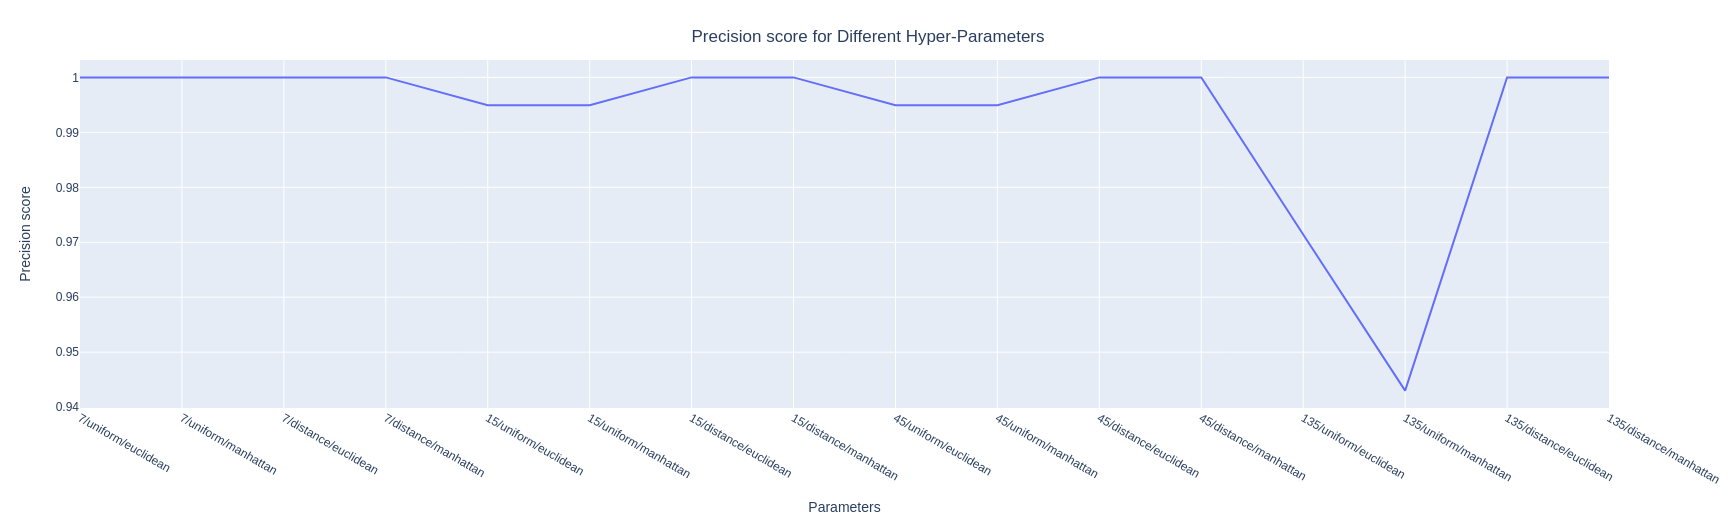

In [132]:
from IPython.display import Image
Image("newplot(2).png", width=1500, height=650)

Del gráfico anterior observamos que:




*   Un valor adecuado para k se puede ser 7, usando cualquier métrica.También se puede hacer uso de $k=45$ y $k=135$, en ambos casos usando la métrica euclidiana o Manhattan

* Para los dos últimos casos en la elección anterior se debe tener en cuenta la distribución de los pesos para los dos últimos casos

Procedemos a implementar nuestro modelo, usaremos $k=7$, pues funciona para cualquier elección de pesos y de métrica:


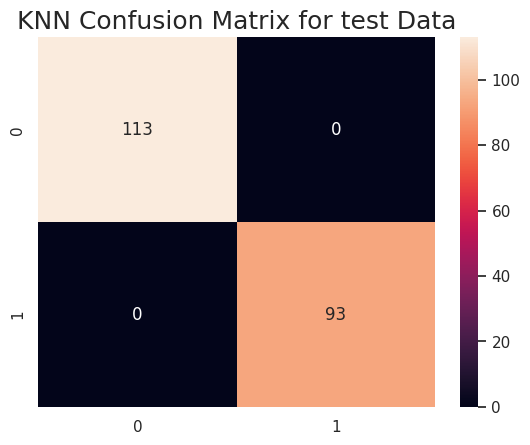

In [135]:
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
plt.title("KNN Confusion Matrix for test Data", fontdict={'fontsize':18})
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

In [139]:
#Desempeño en el conjunto de training
y_pred=knn_model.predict(X_train)
print("Precision score en el conjunto de entrenamiento para KNN : {}%".format(round((precision_score(y_train, y_pred, average='macro')*100),2)))

Precision score en el conjunto de entrenamiento para KNN : 100.0%


In [141]:
#Desempeño en el conjunto de test
y_pred=knn_model.predict(X_validation)
print("Precision score en el conjunto de validación para KNN : {}%".format(round((precision_score(y_validation, y_pred, average='macro')*100),2)))


Precision score en el conjunto de validación para KNN : 100.0%


In [143]:
#Desempeño en el conjunto de test
y_pred=knn_model.predict(X_test)
print("Precision score en el conjunto de test para KNN : {}%".format(round((precision_score(y_test, y_pred, average='macro')*100),2)))
#Precisión del 100% en todos los conjuntos de datos

Precision score en el conjunto de test para KNN : 100.0%


#Implementación decision trees

In [142]:
#Entrenamiento del modelo
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

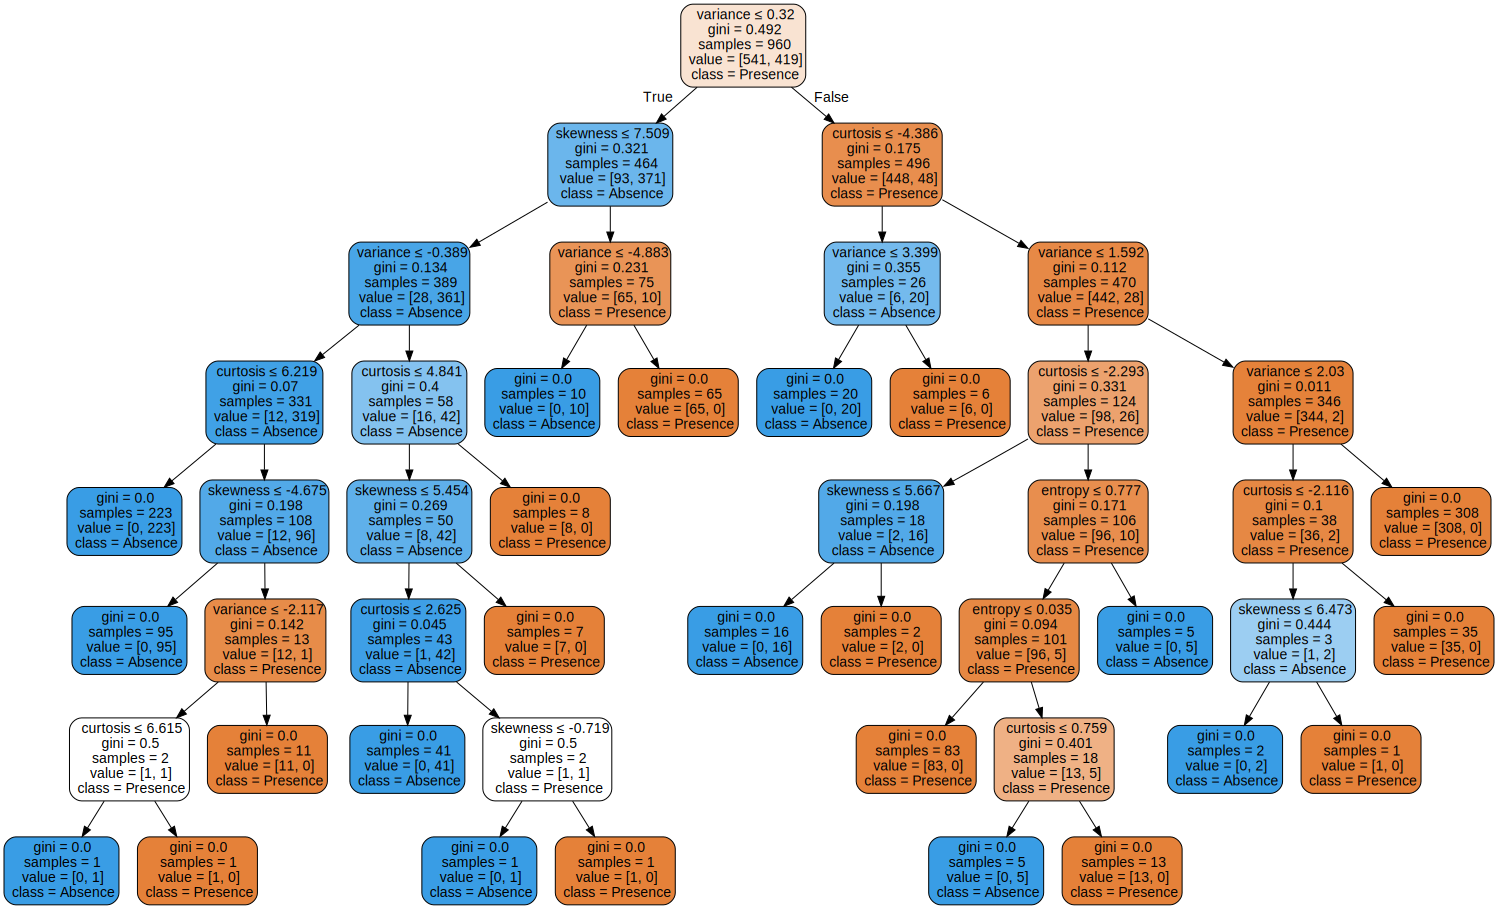

In [144]:
#Visualización del árbol
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=X_train.columns,class_names=["Presence","Absence"],filled=True, rounded=True,special_characters=True) 
#Convertir el archivo generado a png
#!dot -Tpng tree.dot -o tree.png
graph=graphviz.Source(dot_data)
graph

In [150]:
y_pred=clf.predict(X_train)
print("Precision score en el conjunto de entrenamiento para el árbol de decisión : {}%".format(round((precision_score(y_train, y_pred, average='macro')*100),2)))

Precision score en el conjunto de entrenamiento para el árbol de decisión : 100.0%


In [151]:
y_pred=clf.predict(X_validation)
print("Recall score en el conjunto de validación para el árbol de decisión : {}%".format(round((precision_score(y_validation, y_pred, average='macro')*100),2)))

Recall score en el conjunto de validación para el árbol de decisión : 98.03%


In [153]:
y_pred=clf.predict(X_test)
print("Recall score en el conjunto de validación para el árbol de decisión : {}%".format(round((precision_score(y_test, y_pred, average='macro')*100),2)))

Recall score en el conjunto de validación para el árbol de decisión : 97.06%


Claramente estamos un problema de sobreajuste. Exploraremos algunas técnicas para "tunear" hiperparametros

In [168]:
#Hiperparametros del árbol
param_dist={
    "criterion":["gini","entropy"],
    "max_depth":[2,3,4,5,6,None]
}

In [169]:
#Búsqueda en grilla
grid=GridSearchCV(clf,param_grid=param_dist,cv=100,n_jobs=-1)

In [170]:
grid.fit(X_validation,y_validation)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 98 members, which is less than n_splits=100.



GridSearchCV(cv=100, estimator=DecisionTreeClassifier(max_depth=7), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, None]})

In [171]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=5)

In [172]:
grid.best_score_

0.97

In [173]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 5}

In [178]:
clf = tree.DecisionTreeClassifier(criterion= 'gini', max_depth= 5)
clf = clf.fit(X_train, y_train)

In [179]:
y_pred=clf.predict(X_train)
print("Recall score en el conjunto de entrenamineto para el árbol de decisión : {}%".format(round((precision_score(y_train, y_pred, average='macro')*100),2)))

Recall score en el conjunto de entrenamineto para el árbol de decisión : 99.21%


In [180]:
y_pred=clf.predict(X_validation)
print("Recall score en el conjunto de validación para el árbol de decisión : {}%".format(round((precision_score(y_validation, y_pred, average='macro')*100),2)))

Recall score en el conjunto de validación para el árbol de decisión : 95.64%


In [181]:
y_pred=clf.predict(X_test)
print("Recall score en el conjunto de test para el árbol de decisión : {}%".format(round((precision_score(y_test, y_pred, average='macro')*100),2)))

Recall score en el conjunto de test para el árbol de decisión : 97.16%


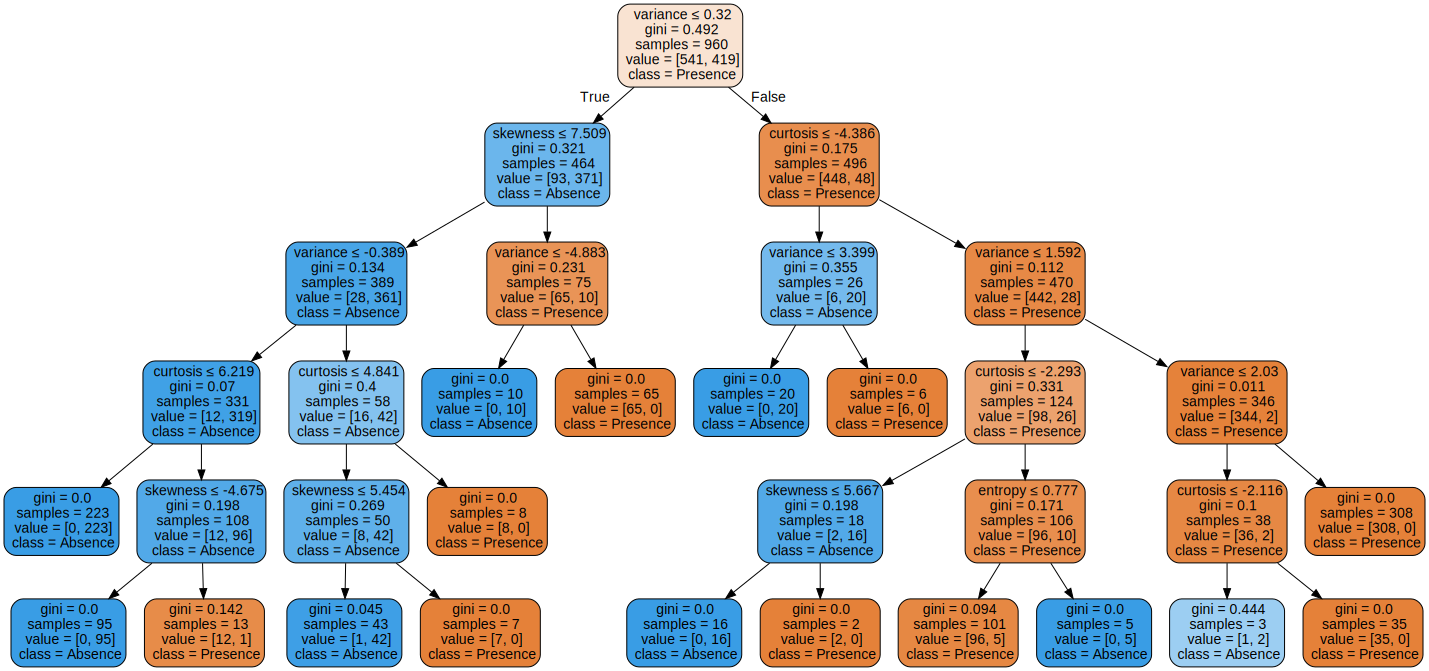

In [183]:
#Visualización del nuevo árbol
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=X_train.columns,class_names=["Presence","Absence"],filled=True, rounded=True,special_characters=True) 
#Convertir el archivo generado a png
#!dot -Tpng tree.dot -o tree.png
graph=graphviz.Source(dot_data)
graph

#Implementación Random Forest

In [184]:
#Random forest hyperparameters

# Numero de árboles del bosque aleatorio
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Numero de características a considerar en cada split
max_features = ['auto', 'sqrt']
# Maximo número de niveles del árbol
max_depth = [2,4]
# Minimo número de muestras para dividir en un nodo
min_samples_split = [2, 5]
#Mínimo número de muestras requeridas para cada hoja
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
#Método para seleccionar muestras para entrenar cada árbol
bootstrap = [True, False]

In [186]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [187]:
rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [189]:
#Usamos "randomized search" porque "grid search" tarda mucho
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [190]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [191]:
rf_RandomGrid.best_params_

{'n_estimators': 25,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 4,
 'bootstrap': True}

In [192]:
rf_Model = RandomForestClassifier(n_estimators= 25,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_features= 'auto',
 max_depth= 4,
 bootstrap =True)

In [193]:
#Modelo con hiperparámetros "tuneados"
rf_Model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



RandomForestClassifier(max_depth=4, max_features='auto', n_estimators=25)

In [194]:
y_pred=rf_Model.predict(X_train)
print("Precision score en el conjunto de entrenamiento para el árbol de decisión : {}%".format(round((precision_score(y_train, y_pred, average='macro')*100),2)))

Precision score en el conjunto de entrenamiento para el árbol de decisión : 98.11%


In [195]:
y_pred=rf_Model.predict(X_validation)
print("Precision score en el conjunto de validación para el árbol de decisión : {}%".format(round((precision_score(y_validation, y_pred, average='macro')*100),2)))

Precision score en el conjunto de validación para el árbol de decisión : 97.08%


In [196]:
y_pred=rf_Model.predict(X_test)
print("Precision score en el conjunto de test para el árbol de decisión : {}%".format(round((precision_score(y_test, y_pred, average='macro')*100),2)))

Precision score en el conjunto de test para el árbol de decisión : 99.02%
